In [66]:
import pyft
import tqdm
import matplotlib.pyplot as plt
import itertools
import statistics
from statistics import mean, median, mode
import seaborn as sns
from scipy.stats import gaussian_kde
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.ticker import StrMethodFormatter, PercentFormatter, MaxNLocator, FuncFormatter
import pysam
import os

### Import data

In [2]:
# Definte replicate and samples
replicate = 'rep_2'
sample_1 = 'pEF_GFP_Gus'
#sample_2 = 'multi_cell_mix'

# pEF-GFP + Gus_WT + Gus_Mut

# Plasmid BAMs
bam_1 = '/gscratch/stergachislab/bmallo/large_home/ft_data/{}/{}/full_length_bams/pEF-GFP/{}_pEF-GFP.bam'.format(sample_1, replicate, replicate)
bam_2 = '/gscratch/stergachislab/bmallo/large_home/ft_data/{}/{}/full_length_bams/Gus_WT/{}_Gus_WT.bam'.format(sample_1, replicate, replicate)
bam_3 = '/gscratch/stergachislab/bmallo/large_home/ft_data/{}/{}/full_length_bams/Gus_Mut/{}_Gus_Mut.bam'.format(sample_1, replicate, replicate)

# Genomic BAMs
bam_g = '/gscratch/stergachislab/bmallo/large_home/ft_data/{}/{}/genomic_bams/{}_all_genomic.bam'.format(sample_1, replicate, replicate)

# setup bam file as fiberbam object
pEF_GFP = pyft.Fiberbam(bam_1)
Gus_WT = pyft.Fiberbam(bam_2)
Gus_Mut = pyft.Fiberbam(bam_3)
GFP_Gus_genomic = pyft.Fiberbam(bam_g)

# multi_cell_mix

## Plasmid BAMs
# bam_4 = '/gscratch/stergachislab/bmallo/large_home/ft_data/{}/{}/full_length_bams/HepG2/{}_HepG2.bam'.format(sample_2, replicate, replicate) # HepG2
# bam_5 = '/gscratch/stergachislab/bmallo/large_home/ft_data/{}/{}/full_length_bams/Hek293/{}_Hek293.bam'.format(sample_2, replicate, replicate) # Hek293
# bam_6 = '/gscratch/stergachislab/bmallo/large_home/ft_data/{}/{}/full_length_bams/A375/{}_A375.bam'.format(sample_2, replicate, replicate) # A375
# bam_7 = '/gscratch/stergachislab/bmallo/large_home/ft_data/{}/{}/full_length_bams/K562/{}_K562.bam'.format(sample_2, replicate, replicate) # K562
# bam_8 = '/gscratch/stergachislab/bmallo/large_home/ft_data/{}/{}/full_length_bams/HAP1/{}_HAP1.bam'.format(sample_2, replicate, replicate) # HAP1

## Genomic BAMs
# bam_9 = '/gscratch/stergachislab/bmallo/large_home/ft_data/{}/{}/genomic_bams/{}_all_genomic.bam'.format(sample_2, replicate, replicate)

## setup bam file as fiberbam object
# HepG2 = pyft.Fiberbam(bam_4)
# Hek293 = pyft.Fiberbam(bam_5)
# A375 = pyft.Fiberbam(bam_6)
# K562 = pyft.Fiberbam(bam_7)
# HAP1 = pyft.Fiberbam(bam_8)
# multi_cell_genomic = pyft.Fiberbam(bam_9)

### Helper Functions

In [3]:
# function for generating a list of all nucleosome lengths from reads aligning to specified plasmid/chromosome
# If chromosome is not specified, function will get nucleosomes for all reads in the sample
def get_nuc_lengths(sample_name, chromosome=None):
    # Set sample and chromosome you want to analyze
    sample = sample_name

    # If chromosome is not specified, consider reads aligning to any chromosome
    if chromosome is None:
        chromosomes_to_analyze = sample.chrom()
    else:
        chromosomes_to_analyze = [chromosome]

    # Generate a list of all nucleosome lengths from reads aligning to specified chromosome(s)
    nuc_length = list(
        itertools.chain.from_iterable([nuc for nuc in fiber.nuc.lengths] for fiber in tqdm.tqdm(sample.fetch(chrom)))
        for chrom in chromosomes_to_analyze
    )

    # Print results
    print(f'nuc_count = {len(nuc_length)}, values = {nuc_length[1:10]}, mean = {mean(nuc_length)}, median = {median(nuc_length)}, mode = {mode(nuc_length)}')

    # Return list of nucleosome lengths
    return nuc_length

In [4]:
# function to plot histogram of nucleosome lengths
def plot_nucleosome_lengths(sample, title, x_label='Nucleosome Length', y_label='Number of Nucleosomes'):
    # Plot the nucleosome length distribution
    nuc_hist = plt.hist(sample, bins=1000, range=(0, 1000), color='teal')

    # Add labels to the plot
    plt.xlabel(x_label, fontsize=11, fontweight='bold')
    plt.ylabel(y_label, fontsize=11, fontweight='bold')
    plt.title(title, fontsize=14, fontweight='bold')

    # Calculate the mean and mode
    mean_length = mean(sample)
    median_length = median(sample)
    mode_length = mode(sample)

    # Plot mean and mode as text annotations
    plt.text(0.62, 0.9, f'Mean = {mean_length:.2f} bp', color='darkgreen', fontsize=12, fontweight='bold', transform=plt.gca().transAxes)
    plt.text(0.62, 0.8, f'Median = {median_length:.2f} bp', color='purple', fontsize=12, fontweight='bold', transform=plt.gca().transAxes)
    plt.text(0.62, 0.7, f'Mode = {mode_length:.2f} bp', color='red', fontsize=12, fontweight='bold', transform=plt.gca().transAxes)

    # Show the plot
    plt.show()

#plt.savefig('/gscratch/stergachislab/bmallo/large_home/ft_data/plasmid_mix_71923/plasmid_mix_unfrozen/genomic_reads/figures/chr2_nuc_lengths.png', dpi=300, bbox_inches='tight')

In [5]:
# function for generating nucleosomes per read (NPR) lists
def get_npr(sample, chrom, min_length, max_length):
    NPR_list = [len([nuc for nuc in fiber.nuc.lengths]) for fiber in sample.fetch(chrom) if min_length <= fiber.get_seq_length() <= max_length]
    print(f'Number of reads: {len(NPR_list)}, mean = {mean(NPR_list)}, mode = {mode(NPR_list)}')
    return NPR_list

In [32]:
# Function to format y-axis ticks by multiplying by 100
def y_format(x, pos):
    return f'{x * 100:.0f}%'

# Function to plot npr histograms
# data_list = npr list, threshold = minimum nucleosome count to include in histogram
def filtered_histogram(data_list, label_list, color_list, threshold=None, replicate=None):
    # Filter data based on the threshold
    if threshold is not None:
        data_list = [list(filter(lambda x: x > threshold, data)) for data in data_list]

    # Create the histogram for all datasets
    n, bins, patches = plt.hist(data_list, bins=max(max(data) for data in data_list) - 5, color=color_list, label=label_list, density=True, histtype='step', linewidth=1.5)

    # Apply custom y-axis formatting
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(y_format))

    # Create custom legend handles with colored lines
    legend_handles = [Line2D([0], [0], color=color, lw=2) for color in color_list]

    plt.legend(legend_handles, label_list)

    # Calculate the mean and mode
    mean_npr = mean([item for sublist in data_list for item in sublist])
    median_npr = median([item for sublist in data_list for item in sublist])
    mode_npr = mode([item for sublist in data_list for item in sublist])


    # Plot mean and mode as text annotations
    plt.text(0.62, 0.9, f'Mean = {mean_npr:.2f} bp', color='darkgreen', fontsize=12, fontweight='bold', transform=plt.gca().transAxes)
    plt.text(0.62, 0.8, f'Median = {median_npr:.2f} bp', color='purple', fontsize=12, fontweight='bold', transform=plt.gca().transAxes)
    plt.text(0.62, 0.7, f'Mode = {mode_npr:.2f} bp', color='red', fontsize=12, fontweight='bold', transform=plt.gca().transAxes)

    # Add labels and title
    plt.xlabel('Nucleosomes per Read')
    plt.ylabel('Percent of Reads')
    plt.title('Nucleosomes per Read ({})'.format(replicate))
    #plt.savefig('/gscratch/stergachislab/bmallo/large_home/ft_data/multi_cell_mix/rep_3/Figures/5+_nucs_per_read.jpg', dpi=300)

In [ ]:
# Function to plot density plots with x values greater than 5
def plot_density_greater_than_5(data, label, color):
    filtered_data = [x for x in data if x > 0]  # Filter data greater than 0
    sns.kdeplot(filtered_data, color=color, label=label, linewidth=1.5)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
data = [HepG2_count, Hek293_count, A375_count, K562_count, HAP1_count]
labels = ['HepG2_count', 'Hek293_count', 'A375_count', 'K562_count', 'HAP1_count']

for i in range(len(data)):
    plot_density_greater_than_5(data[i], labels[i], colors[i])

plt.xlabel('Number of Nucleosomes')  # Replace with your desired label
plt.ylabel('Percentage of Reads')  # Replace with your desired label
plt.title('Nucleosomes per Read Across Cell Types (Rep. 2)')  # Replace with your desired title

plt.legend()

# Function to format y-axis ticks by multiplying by 100
def y_format(x, pos):
    return f'{x * 100:.0f}%'

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(y_format))
plt.savefig('/gscratch/stergachislab/bmallo/large_home/ft_data/multi_cell_mix/rep_2/Figures/downsampled_nucleosomes_per_read.jpg', dpi=300)
#plt.show()



In [8]:
# Function for generating base pairs per nucleosome (BPN) list
def get_BPN(sample, chrom, min_length, max_length):
    BPN_list = [round(fiber.get_seq_length() / (len([nuc for nuc in fiber.nuc.lengths]) or 1), 2) for fiber in sample.fetch(chrom) if min_length <= fiber.get_seq_length() <= max_length]
    print(len(BPN_list))
    return BPN_list

In [9]:
# Define function for getting read lengths
def get_read_lengths(sample, chrom):
    read_length = list(itertools.chain.from_iterable([fiber.get_seq_length()] for fiber in sample.fetch(chrom)))
    print(f'Number of reads = {len(read_length)}')
    return read_length

In [10]:
# Set function for generating a list of all nucleosome lengths from reads aligning to specified chromosome. Needed for nuc_length_for_npr
def get_nuc_lengths(sample_name, chromosome):
    # Set sample and chromosome you want to analyze
    sample = sample_name
    chrom = chromosome
    
    # Generate a list of all nucleosome lengths from reads aligning to specified chromosome
    nuc_length = list(itertools.chain.from_iterable([nuc for nuc in fiber.nuc.lengths] for fiber in (sample.fetch(chrom))))

    # Return list of nucleosome lengths
    return nuc_length

# Function for plotting average nucleosome size as a function of nucleosomes per read
def nuc_length_for_npr(sample, replicate, chrom):
    bam_directory = '/gscratch/stergachislab/bmallo/large_home/ft_data/{}/{}/full_length_bams/{}/nuc_count_filtered_bams/'.format(sample, replicate, chrom)

    mean_nuc_size = []
    median_nuc_size = []
    mode_nuc_size = []

    for i in range(1, 50):
        bam_file_path = f"{bam_directory}{i}_nucleosomes.bam"

        # Check if the BAM file exists
        if not os.path.exists(bam_file_path):
            print(f"Skipping {bam_file_path} because it does not exist.")
            continue

        # Open the BAM file if it exists
        bam_file = pyft.Fiberbam(bam_file_path)
        nuc_lengths = get_nuc_lengths(bam_file, chrom)
        mean_length = mean(nuc_lengths)
        median_length = median(nuc_lengths)
        mode_length = mode(nuc_lengths)
        mean_nuc_size.append(mean_length)
        median_nuc_size.append(median_length)
        mode_nuc_size.append(mode_length)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(mean_nuc_size, label='Mean Nucleosome Size')
    plt.plot(median_nuc_size, label='Median Nucleosome Size')
    plt.plot(mode_nuc_size, label='Mode Nucleosome Size')

    plt.title('Nucleosome Size Analysis')
    plt.xlabel('File Index')
    plt.ylabel('Nucleosome Size')
    plt.legend()
    plt.show()

    return mean_nuc_size, median_nuc_size, mode_nuc_size


In [11]:
# Function for generating list of all genomic nucleosome lengths
def get_genomic_nuc_lengths(sample, chromosomes):
    genomic_nuc_length_list = []

    for chrom in chromosomes:
        for fiber in sample.fetch(chrom):
            nuc_lengths = fiber.nuc.lengths
            genomic_nuc_length_list.append(nuc_lengths)

    return genomic_nuc_length_list

In [12]:
def get_genomic_read_lengths(sample, chromosomes):
    genomic_read_length_list = []

    for chrom in chromosomes:
        for fiber in sample.fetch(chrom):
            read_lengths = fiber.get_seq_length()
            genomic_read_length_list.append(read_lengths)

    return genomic_read_length_list

In [13]:
def plot_m6a(sample, chrom, ax=None):
    # Generate a list containing the number of m6A calls per read
    percent_methylated = []
    for fiber in sample.fetch(chrom):
        AT_count = fiber.seq.count('A') + fiber.seq.count('T')
        m6a_count = len(fiber.m6a.starts)
        percent_methylated.append(m6a_count/AT_count)
    
    # If ax is not provided, create a new subplot
    if ax is None:
        fig, ax = plt.subplots()

    # Plotting on the specified axis (or the newly created subplot)
    ax.hist(percent_methylated, bins='auto', edgecolor='black', label=f'{chrom}')
    ax.set_xlabel('% Methylated', fontsize=11, fontweight='bold')
    ax.set_ylabel('Read Count', fontsize=11, fontweight='bold')
    ax.set_title(f'{chrom}', fontsize=14, fontweight='bold')
    ax.legend()

def genomic_plot_m6a(sample, g_chroms, ax=None):
    methylated_ratio = []
    for chrom in g_chroms:
        for fiber in sample.fetch(chrom):
            AT_count = fiber.seq.count('A') + fiber.seq.count('T')
            m6a_count = len(fiber.m6a.starts)
            methylated_ratio.append(m6a_count/AT_count)
    
    # If ax is not provided, create a new subplot
    if ax is None:
        fig, ax = plt.subplots()

    # Plotting on the specified axis (or the newly created subplot)
    ax.hist(methylated_ratio, bins='auto', edgecolor='black', label=f'{chrom}')
    ax.set_xlabel('% Methylated', fontsize=11, fontweight='bold')
    ax.set_ylabel('Read Count', fontsize=11, fontweight='bold')
    ax.set_title('Genomic', fontsize=14, fontweight='bold')
    ax.legend()

[2024-01-17T17:34:34Z INFO  pyft::fiberdata] 75636 records fetched in 142.64s
[2024-01-17T17:34:39Z INFO  pyft::fiberdata] Fiberdata made for 75636 records in 4.40s
[2024-01-17T17:34:44Z INFO  pyft::fiberdata] 61239 records fetched in 152.02s
[2024-01-17T17:34:48Z INFO  pyft::fiberdata] Fiberdata made for 61239 records in 3.87s
[2024-01-17T17:34:53Z INFO  pyft::fiberdata] 73413 records fetched in 161.48s
[2024-01-17T17:34:58Z INFO  pyft::fiberdata] Fiberdata made for 73413 records in 4.74s
[2024-01-17T17:35:04Z INFO  pyft::fiberdata] 17590 records fetched in 171.72s
[2024-01-17T17:35:05Z INFO  pyft::fiberdata] Fiberdata made for 17590 records in 0.89s
[2024-01-17T17:35:06Z INFO  pyft::fiberdata] 8683 records fetched in 1.46s
[2024-01-17T17:35:07Z INFO  pyft::fiberdata] Fiberdata made for 8683 records in 0.53s
[2024-01-17T17:35:08Z INFO  pyft::fiberdata] 23091 records fetched in 1.22s
[2024-01-17T17:35:09Z INFO  pyft::fiberdata] Fiberdata made for 23091 records in 1.28s
[2024-01-17T17:3

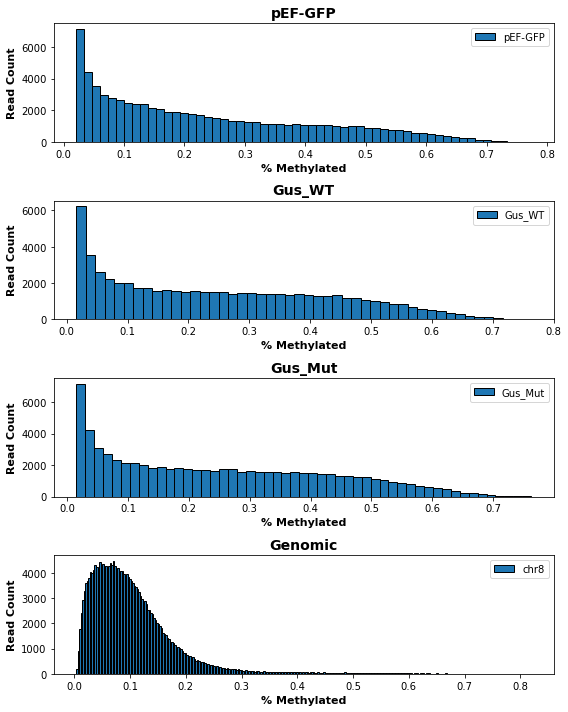

In [14]:
g_chroms = {'chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX', 'chrY'}

fig, axes = plt.subplots(4,1, figsize=(8, 10))

plot_m6a(pEF_GFP, 'pEF-GFP', ax=axes[0])

plot_m6a(Gus_WT, 'Gus_WT', ax=axes[1])

plot_m6a(Gus_Mut, 'Gus_Mut', ax=axes[2])

genomic_plot_m6a(GFP_Gus_genomic, g_chroms, ax=axes[3])

plt.tight_layout()

## Plasmid Analysis

#### Get read lengths

In [15]:
pEF_GFP_read_lengths = get_read_lengths(pEF_GFP, 'pEF-GFP')

[2024-01-17T17:36:51Z INFO  pyft::fiberdata] 75636 records fetched in 131.81s
[2024-01-17T17:36:54Z INFO  pyft::fiberdata] Fiberdata made for 75636 records in 3.72s


Number of reads = 75636


#### Get nucleosome lengths

In [21]:
pEF_GFP_nuc_lenghts = get_nuc_lengths(pEF_GFP, 'pEF-GFP')
Gus_WT_nuc_lengths = get_nuc_lengths(Gus_WT, 'Gus_WT')
Gus_Mut_nuc_lengths = get_nuc_lengths(Gus_Mut, 'Gus_Mut')

[2024-01-17T17:40:13Z INFO  pyft::fiberdata] 75636 records fetched in 135.24s
[2024-01-17T17:40:17Z INFO  pyft::fiberdata] Fiberdata made for 75636 records in 4.06s
[2024-01-17T17:40:20Z INFO  pyft::fiberdata] 61239 records fetched in 135.36s
[2024-01-17T17:40:24Z INFO  pyft::fiberdata] Fiberdata made for 61239 records in 4.18s
[2024-01-17T17:40:27Z INFO  pyft::fiberdata] 73413 records fetched in 135.01s
[2024-01-17T17:40:32Z INFO  pyft::fiberdata] Fiberdata made for 73413 records in 5.01s


#### Get nucleosomes per read

In [17]:
# Define chrom and read lengths

# # pEF-GFP lengths = 5024 - 5084
pEF_GFP_count = get_npr(pEF_GFP,'pEF-GFP', 5000, 5100)
Gus_WT_count = get_npr(Gus_WT,'Gus_WT', 6410, 6510)
Gus_Mut_count = get_npr(Gus_Mut,'Gus_Mut', 6410, 6510)

# # Gus plasmid lengths = 6432 - 6492
# HepG2_count = get_npr(HepG2,'HepG2', 5000, 5100)
# Hek293_count = get_npr(Hek293,'Hek293', 5000, 5100)
# A375_count = get_npr(A375,'A375', 5000, 5100)
# K562_count = get_npr(K562,'K562', 5000, 5100)
# HAP1_count = get_npr(HAP1,'HAP1', 5000, 5100)

[2024-01-17T17:37:09Z INFO  pyft::fiberdata] 75636 records fetched in 4.75s
[2024-01-17T17:37:13Z INFO  pyft::fiberdata] Fiberdata made for 75636 records in 3.60s


Number of reads: 75636, mean = 13.321103707229362, mode = 19


[2024-01-17T17:37:15Z INFO  pyft::fiberdata] 61239 records fetched in 147.32s
[2024-01-17T17:37:19Z INFO  pyft::fiberdata] Fiberdata made for 61239 records in 3.65s


Number of reads: 61239, mean = 16.27315926125508, mode = 0


[2024-01-17T17:37:21Z INFO  pyft::fiberdata] 73413 records fetched in 143.33s
[2024-01-17T17:37:26Z INFO  pyft::fiberdata] Fiberdata made for 73413 records in 4.44s


Number of reads: 73413, mean = 16.448394698486645, mode = 0


#### Get bp per nucleosome

In [18]:
pEF_GFP_BPN = get_BPN(pEF_GFP, 'pEF-GFP', 5000, 5100)
Gus_WT_BPN = get_BPN(Gus_WT, 'Gus_WT', 6410, 6510)
Gus_Mut_BPN = get_BPN(Gus_Mut, 'Gus_Mut', 6410, 6510)

[2024-01-17T17:37:54Z INFO  pyft::fiberdata] 75636 records fetched in 41.51s
[2024-01-17T17:37:58Z INFO  pyft::fiberdata] Fiberdata made for 75636 records in 3.59s


75636


[2024-01-17T17:38:00Z INFO  pyft::fiberdata] 61239 records fetched in 41.65s
[2024-01-17T17:38:04Z INFO  pyft::fiberdata] Fiberdata made for 61239 records in 3.86s


61239


[2024-01-17T17:38:07Z INFO  pyft::fiberdata] 73413 records fetched in 41.13s
[2024-01-17T17:38:12Z INFO  pyft::fiberdata] Fiberdata made for 73413 records in 4.63s


73413


#### Get nucleosome length as a function of npr

In [ ]:
pEF_GFP_nl_npr = nuc_length_for_npr(pEF_GFP, 'pEF-GFP', 'pEF-GFP')

#### Plot read lengths

#### Plot nucleosome lengths

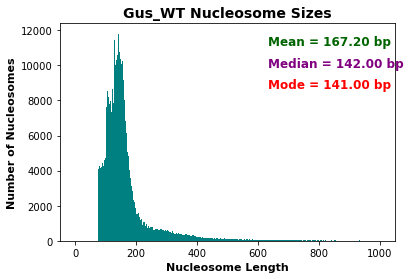

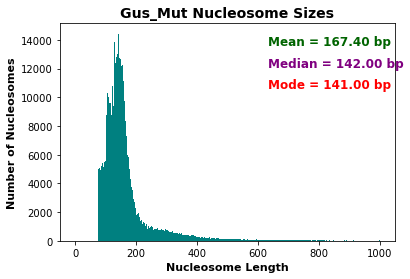

In [23]:
plot_nucleosome_lengths(Gus_WT_nuc_lengths, 'Gus_WT Nucleosome Sizes')
plot_nucleosome_lengths(Gus_Mut_nuc_lengths, 'Gus_Mut Nucleosome Sizes')
#plot_nucleosome_lengths(A375_nucs, 'A375 Nucleosome Sizes')
# plot_nucleosome_lengths(K562_nucs, 'K562 Nucleosome Sizes')
# plot_nucleosome_lengths(HAP1_nucs, 'HAP1 Nucleosome Sizes')


#### Plot nucleosomes per read

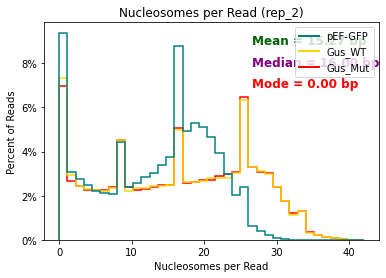

In [33]:
filtered_histogram([pEF_GFP_count, Gus_WT_count, Gus_Mut_count], ['pEF-GFP', 'Gus_WT', 'Gus_Mut'], ['teal', 'gold', 'red'], replicate='rep_2')

#### Plot bp per nucleosome

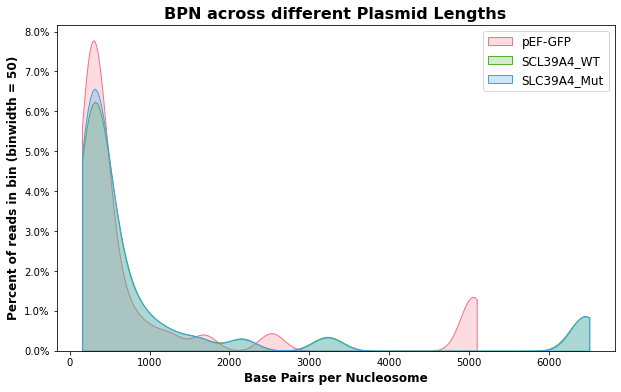

In [82]:
def plot_multiple_datasets(datasets, labels, figsize = (10, 6), legend_fontsize = 12):
    """
    Plot multiple datasets on the same KDE plot.

    Parameters:
    - datasets: List of datasets to be plotted.
    - labels: List of labels for each dataset (to be used in the legend).
    """

    plt.figure(figsize=figsize)

     # Define distinguishable colors
    palette = sns.color_palette("husl", n_colors=len(datasets))

    for data, label, color in zip(datasets, labels, palette):
        ax = sns.kdeplot(data, label=label, shade=True, color=color, cut=0)
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    # Set labels and title
    plt.xlabel('Base Pairs per Nucleosome', fontsize=12, fontweight='bold')
    plt.title('BPN across different Plasmid Lengths', fontsize=16, fontweight='bold')

    binwidth = 50
    ax.yaxis.set_major_formatter(PercentFormatter(1/binwidth))
    ax.set_ylabel(f'Percent of reads in bin (binwidth = {binwidth})', fontsize=12, fontweight='bold')

    # Show legend
    plt.legend(fontsize=legend_fontsize)

    plt.savefig('/gscratch/stergachislab/bmallo/large_home/ft_data/pEF_GFP_Gus/rep_2/Figures/all_plasmid_BPN_density.png', dpi=300, bbox_inches='tight')

labels = ['pEF-GFP', 'SCL39A4_WT', 'SLC39A4_Mut']
plot_multiple_datasets([pEF_GFP_BPN, Gus_WT_BPN ,Gus_Mut_BPN], labels)

In [85]:
filtered_pEF_GFP_BPN = [x for x in pEF_GFP_BPN if 150 <= x <= 1000]
filtered_Gus_WT_BPN = [x for x in Gus_WT_BPN if 150 <= x <= 1000]
filtered_Gus_Mut_BPN = [x for x in Gus_Mut_BPN if 150 <= x <= 1000]

print(mode(filtered_pEF_GFP_BPN))
print(mode(filtered_Gus_WT_BPN))
print(mode(filtered_Gus_Mut_BPN))   

266.21
248.69
258.64


#### Plot nucleosome length as a function of npr

## Genomic Analysis

### Get all nucleosome lengths from genomic BAM

In [ ]:
# Generate nucleosome length lists
chromosomes = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX', 'chrY']

GFP_Gus_genomic_nuc_lengths = get_genomic_nuc_lengths(GFP_Gus_genomic, chromosomes)
Multi_cell_genomic_nuc_lengths = get_genomic_nuc_lengths(multi_cell_genomic, chromosomes)
# pEF_GFP_nucs = get_nuc_lengths(pEF_GFP, "pEF-GFP")
# Gus_WT_nucs = get_nuc_lengths(Gus_WT, "Gus_WT")
# Gus_Mut_nucs = get_nuc_lengths(Gus_Mut, "Gus_Mut")
# K562_nucs = get_nuc_lengths(K562, "K562")
# HAP1_nucs = get_nuc_lengths(HAP1, "HAP1")

### Get all read lengths from genomic BAM

In [ ]:
chromosomes = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX', 'chrY']

GFP_Gus_genomic_read_lengths = get_genomic_read_lengths(GFP_Gus_genomic, chromosomes)
Multi_cell_genomic_read_lengths = get_genomic_read_lengths(multi_cell_genomic, chromosomes)

In [ ]:
plt.hist(read_length_list, range=(5000, 5100), bins=50)

In [ ]:
# Plot nucleosome lengths on the same plot
plt.hist(HepG2_nucs, bins=100, range=(0,1000), color='seagreen', label='Gus WT', density=True, histtype='step', linewidth=1)
plt.hist(Hek293_nucs, bins=100, range=(0,1000), color='royalblue', label='Gus_MUT', density=True, histtype='step', linewidth=1)
plt.hist(A375_nucs, bins=1000, range=(0,1000), color='darkorange', label='pEF GFP', density=True, histtype='step', linewidth=1)
plt.hist(K562_nucs, bins=1000, range=(0,1000), color='purple', label='pEF GFP', density=True, histtype='step', linewidth=1)
plt.hist(HAP1_nucs, bins=1000, range=(0,1000), color='red', label='pEF GFP', density=True, histtype='step', linewidth=1)


# Add labels to the plot
plt.xlabel('Nucleosomes Lengths', fontsize=11, fontweight='bold')
plt.ylabel('Normalized Read Count', fontsize=11, fontweight='bold')
plt.title('Nucleosomes per Read (WT vs MUT)', fontsize=14, fontweight='bold')